In [1]:
import requests
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch
import random
from pytorch_lightning import seed_everything
seed = 12
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(seed)

url = 'https://gist.githubusercontent.com/skywalker0803r/e0ef295d69aba240e6ff1537be354bc8/raw/eab83e022de41cfedf1644bd4e5752c97b2488f8/Modeling.py'
exec(requests.get(url).text)

Global seed set to 12


In [2]:
import joblib
data = joblib.load('data.pkl')
merged_df = data['merged_df']
input_col = data['input_col']
output_col = data['output_col']


In [3]:
sorted(merged_df.columns.tolist())[:10]

['ProductDSARRDS2',
 'ProductDSARRDS2.1',
 'ProductDSARRDS2.10',
 'ProductDSARRDS2.11',
 'ProductDSARRDS2.12',
 'ProductDSARRDS2.13',
 'ProductDSARRDS2.14',
 'ProductDSARRDS2.15',
 'ProductDSARRDS2.16',
 'ProductDSARRDS2.17']

In [4]:
url = 'https://gist.githubusercontent.com/skywalker0803r/c92f4651ccbd0640c2a8c97c017092d9/raw/adedbf1159e92402f32b8d961f6db70a1b0c95ad/DataPreprocessingArmory.py'
exec(requests.get(url).text)

In [5]:
x_col = set(merged_df.columns)&set(input_col)
y_col = set(merged_df.columns)&set(output_col)
len(x_col),len(y_col),len(input_col),len(output_col)

(113, 47, 113, 47)

In [6]:
x_col.issubset(input_col) ,y_col.issubset(output_col) 

(True, True)

In [7]:
train_loader,val_loader = df_2_torch_data_iter(df=merged_df,x_col=x_col,y_col=y_col,test_size=0.2,random_state=seed,batch_size=7)

In [8]:
model = build_mlp(
    layers = [len(x_col),128,128,len(y_col)],
    activation_function = nn.ReLU(),
    output_activation_function = nn.Sigmoid(),
    )
model

Sequential(
  (0): Linear(in_features=113, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=47, bias=True)
  (5): Sigmoid()
)

In [9]:
import torch
from tqdm import tqdm
from copy import deepcopy

def step(model,batch,optimizer,device,loss_fn,mode='train'):
    '''
    這個函數實現了模型前向&後向傳播的過程,稱之為step
    '''
    # model to device
    model = model.to(device)
    # change mode(train/val)
    if mode == 'train':
        model.train()
    if mode == 'val':
        model.eval()
    # model forward pass
    x,y = batch
    x = x.to(device)
    y = y.to(device)
    output = model(x)
    loss = loss_fn(y,output)
    # update model if mode == train
    if mode == 'train': 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,device,loss_fn,max_epochs=12):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    for epoch in tqdm(range(max_epochs)):        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        for i,batch in enumerate(train_loader):
            epoch_train_loss += step(model,batch,optimizer,device,loss_fn,mode='train')
        for j,batch in enumerate(val_loader):
            epoch_val_loss += step(model,batch,optimizer,device,loss_fn,mode='val')
        history['train_loss'].append(epoch_train_loss/(i+1))
        history['val_loss'].append(epoch_val_loss/(j+1))
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/(i+1)} val_loss:{epoch_val_loss/(j+1)}')
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')
    return best_model.eval() ,history

optimizer = torch.optim.Adam(
    params = model.parameters(),
    lr = 1e-3)
device = 'cpu'
loss_fn = nn.SmoothL1Loss()
best_model ,history = train_loop(model,train_loader,val_loader,optimizer,device,loss_fn,max_epochs=100)

 14%|█▍        | 14/100 [00:00<00:00, 131.06it/s]

epoch:0 train_loss:0.04177649598568678 val_loss:0.03124733828008175
save best_model now_val_best_loss is:0.03124733828008175
epoch:1 train_loss:0.03900280874222517 val_loss:0.028774630278348923
save best_model now_val_best_loss is:0.028774630278348923
epoch:2 train_loss:0.036057026125490665 val_loss:0.026228483766317368
save best_model now_val_best_loss is:0.026228483766317368
epoch:3 train_loss:0.033633201848715544 val_loss:0.024401331320405006
save best_model now_val_best_loss is:0.024401331320405006
epoch:4 train_loss:0.032288978807628155 val_loss:0.023246927186846733
save best_model now_val_best_loss is:0.023246927186846733
epoch:5 train_loss:0.03140040813013911 val_loss:0.022412609308958054
save best_model now_val_best_loss is:0.022412609308958054
epoch:6 train_loss:0.03064885176718235 val_loss:0.021931329742074013
save best_model now_val_best_loss is:0.021931329742074013
epoch:7 train_loss:0.030022671911865473 val_loss:0.021547826007008553
save best_model now_val_best_loss is:0.0

 42%|████▏     | 42/100 [00:00<00:00, 133.16it/s]

epoch:24 train_loss:0.015328767942264676 val_loss:0.015544583089649677
epoch:25 train_loss:0.015092830872163177 val_loss:0.015527606010437012
epoch:26 train_loss:0.014846455305814743 val_loss:0.015507210977375507
epoch:27 train_loss:0.014602505369111896 val_loss:0.015464193187654018
epoch:28 train_loss:0.014387988019734621 val_loss:0.015409269370138645
epoch:29 train_loss:0.014173268340528011 val_loss:0.015390250831842422
epoch:30 train_loss:0.013989725848659873 val_loss:0.015387295745313168
epoch:31 train_loss:0.013813969446346164 val_loss:0.015398218296468258
epoch:32 train_loss:0.013661238830536604 val_loss:0.015395531430840492
epoch:33 train_loss:0.013523454079404473 val_loss:0.015387258492410183
epoch:34 train_loss:0.01339422701857984 val_loss:0.015412175096571445
epoch:35 train_loss:0.013287434354424477 val_loss:0.015430476516485214
epoch:36 train_loss:0.013181583723053336 val_loss:0.015430203638970852
epoch:37 train_loss:0.013087255414575338 val_loss:0.01542653702199459
epoch:38

 68%|██████▊   | 68/100 [00:00<00:00, 130.16it/s]

epoch:50 train_loss:0.01190401311032474 val_loss:0.015290599316358566
epoch:51 train_loss:0.011791423545219004 val_loss:0.015269850380718708
save best_model now_val_best_loss is:0.015269850380718708
epoch:52 train_loss:0.011696703149937093 val_loss:0.015279951505362988
epoch:53 train_loss:0.011589032365009189 val_loss:0.015269409865140915
save best_model now_val_best_loss is:0.015269409865140915
epoch:54 train_loss:0.011482084169983864 val_loss:0.015206647105515003
save best_model now_val_best_loss is:0.015206647105515003
epoch:55 train_loss:0.01136532612144947 val_loss:0.015201972797513008
save best_model now_val_best_loss is:0.015201972797513008
epoch:56 train_loss:0.01126302604097873 val_loss:0.01521767396479845
epoch:57 train_loss:0.011149359866976738 val_loss:0.01519713643938303
save best_model now_val_best_loss is:0.01519713643938303
epoch:58 train_loss:0.011031693546101451 val_loss:0.015160002745687962
save best_model now_val_best_loss is:0.015160002745687962
epoch:59 train_loss

100%|██████████| 100/100 [00:00<00:00, 134.71it/s]

save best_model now_val_best_loss is:0.015035784803330898
epoch:74 train_loss:0.009200337692163885 val_loss:0.015089861117303371
epoch:75 train_loss:0.009086708421818912 val_loss:0.015101412311196327
epoch:76 train_loss:0.008979764650575817 val_loss:0.015018955804407597
save best_model now_val_best_loss is:0.015018955804407597
epoch:77 train_loss:0.008885472198016942 val_loss:0.015069322660565376
epoch:78 train_loss:0.008781522861681879 val_loss:0.015064364299178123
epoch:79 train_loss:0.008681389619596303 val_loss:0.015056224539875984
epoch:80 train_loss:0.008587488089688122 val_loss:0.015109997242689133
epoch:81 train_loss:0.008489254978485405 val_loss:0.015010381117463112
save best_model now_val_best_loss is:0.015010381117463112
epoch:82 train_loss:0.008403258863836527 val_loss:0.015061295591294765
epoch:83 train_loss:0.008318664971739054 val_loss:0.01507723331451416
epoch:84 train_loss:0.008220867835916579 val_loss:0.0151071697473526
epoch:85 train_loss:0.008145150728523731 val_los

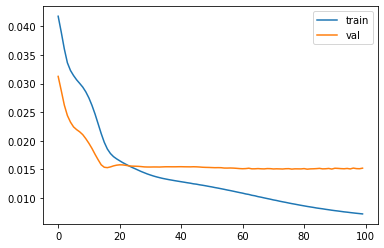

In [10]:
import matplotlib.pyplot as plt
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import r2_score,mean_squared_error
from numpy import sqrt

def mape(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

y_pred = model(torch.FloatTensor(merged_df[x_col].values))
y_real = torch.FloatTensor(merged_df[y_col].values)
print('r2:',r2_score(y_real.detach().numpy(),y_pred.detach().numpy()))
print('rmse:',sqrt(mean_squared_error(y_real.detach().numpy(),y_pred.detach().numpy())))
print('mape:',mape(y_real.detach().numpy(),y_pred.detach().numpy()))

r2: 0.6568991523310548
rmse: 0.13299525
mape: 0.38943928


In [20]:
df_pred = pd.DataFrame()
for v,col in zip(y_pred,y_col):
    df_pred[col] = v.detach().numpy()
df_real = pd.DataFrame()
for v,col in zip(y_real,y_col):
    df_real[col] = v.detach().numpy()

In [28]:
df_metrics = pd.DataFrame()
for a,b,c in zip(y_real,y_pred,y_col):
    df_metrics.loc[c,'r2_score'] = r2_score(a.detach().numpy(),b.detach().numpy())
    df_metrics.loc[c,'rmse'] = sqrt(mean_squared_error(a.detach().numpy(),b.detach().numpy()))
    df_metrics.loc[c,'mape'] = mape(a.detach().numpy(),b.detach().numpy())
df_metrics

,r2_score,rmse,mape
ProductDSARRDS2.22,0.994646,0.026991,0.055353
ProductDSLGORDS2.23,0.752868,0.139220,0.485589
ProductDSARRDS2.15,0.913852,0.078946,0.220196
ProductDSARRDS2.2,0.881055,0.099057,0.478650
ProductDSARRDS2.11,0.825993,0.106881,0.398968
ProductDSARRDS2.1,0.903884,0.073663,0.448968
ProductDSARRDS2.7,0.857233,0.085308,0.266486
ProductDSARRDS2.21,-0.331745,0.309646,2.542251
ProductDSLGORDS2.8,0.874890,0.092661,0.243605
ProductDSARRDS2.4,0.923896,0.085830,0.308224
